In [1]:
# pip install elevation rasterio richdem python-srtm utm
import os # get current working directory
import elevation as dem
import richdem as rd
import rasterio as rio
from rasterio.plot import show
import osmnx as ox
import matplotlib.pyplot as plt
import utm
from rasterio.warp import reproject, Resampling, transform
import numpy as np

# Install gdal according to python version: GDAL-3.4.2-cp39-cp39-win_amd64.whl
# Install fiona according to python version: https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona
import geopandas as gpd

# turn response caching off/on
# ox.settings.use_cache = False

In [2]:
!eio selfcheck

Your system is ready.


In [13]:
# Method-1
# clip the SRTM1 30m DEM of Rammelsberg and save it to Rammelsberg-DEM.tif
roi = (51.8903, 10.41933) # Rammelsberg Coordinates
bbx = (roi[1]-0.05, roi[0]-0.05, roi[1]+0.05, roi[0]+0.05)

# print(bbx)
# The --bounds option accepts latitude and longitude coordinates (more precisely in geodetic coordinates in the WGS84 reference system EPSG:4326 for those who care) given as left bottom right top similarly to the rio command form rasterio.
# !eio clip -o Rammelsberg-DEM --bounds bbx[0] bbx[1] bbx[2] bbx[3]

(10.36933, 51.840300000000006, 10.469330000000001, 51.9403)
Usage: eio clip [OPTIONS]
Try "eio clip --help" for help.

Error: Invalid value for "--bounds": bbx[0] is not a valid floating point value


In [2]:
# Method2
# clip the SRTM1 30m DEM of Rammelsberg and save it to Rammelsberg-DEM.tif
roi = (51.8903, 10.41933) # Rammelsberg Coordinates (Lat, Lng)
fname = f"{os.getcwd()}/Rammelsberg-DEM.tif"
print(fname)
offset = 0.01
bbx = (roi[1]-offset, roi[0]-offset, roi[1]+offset, roi[0]+offset)
dem.clip(bounds=(bbx[0], bbx[1], bbx[2], bbx[3]), output=fname, product='SRTM1')
dem.clean() # clean up stale temporary files and fix the cache in the event of a server error

/home/ahmad/personal_ws/src/ROSExamples/script/Rammelsberg-DEM.tif
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.bafe0a83a8e243188c31f37ca27e5c92.vrt
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 10.40933 51.9003 10.42933 51.880300000000005 SRTM1.bafe0a83a8e243188c31f37ca27e5c92.vrt /home/ahmad/personal_ws/src/ROSExamples/script/Rammelsberg-DEM.tif
rm -f SRTM1.bafe0a83a8e243188c31f37ca27e5c92.vrt
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Enterin

ERROR 1: PROJ: proj_create_from_name: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed
Warning 1: PROJ: proj_create_from_database: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed


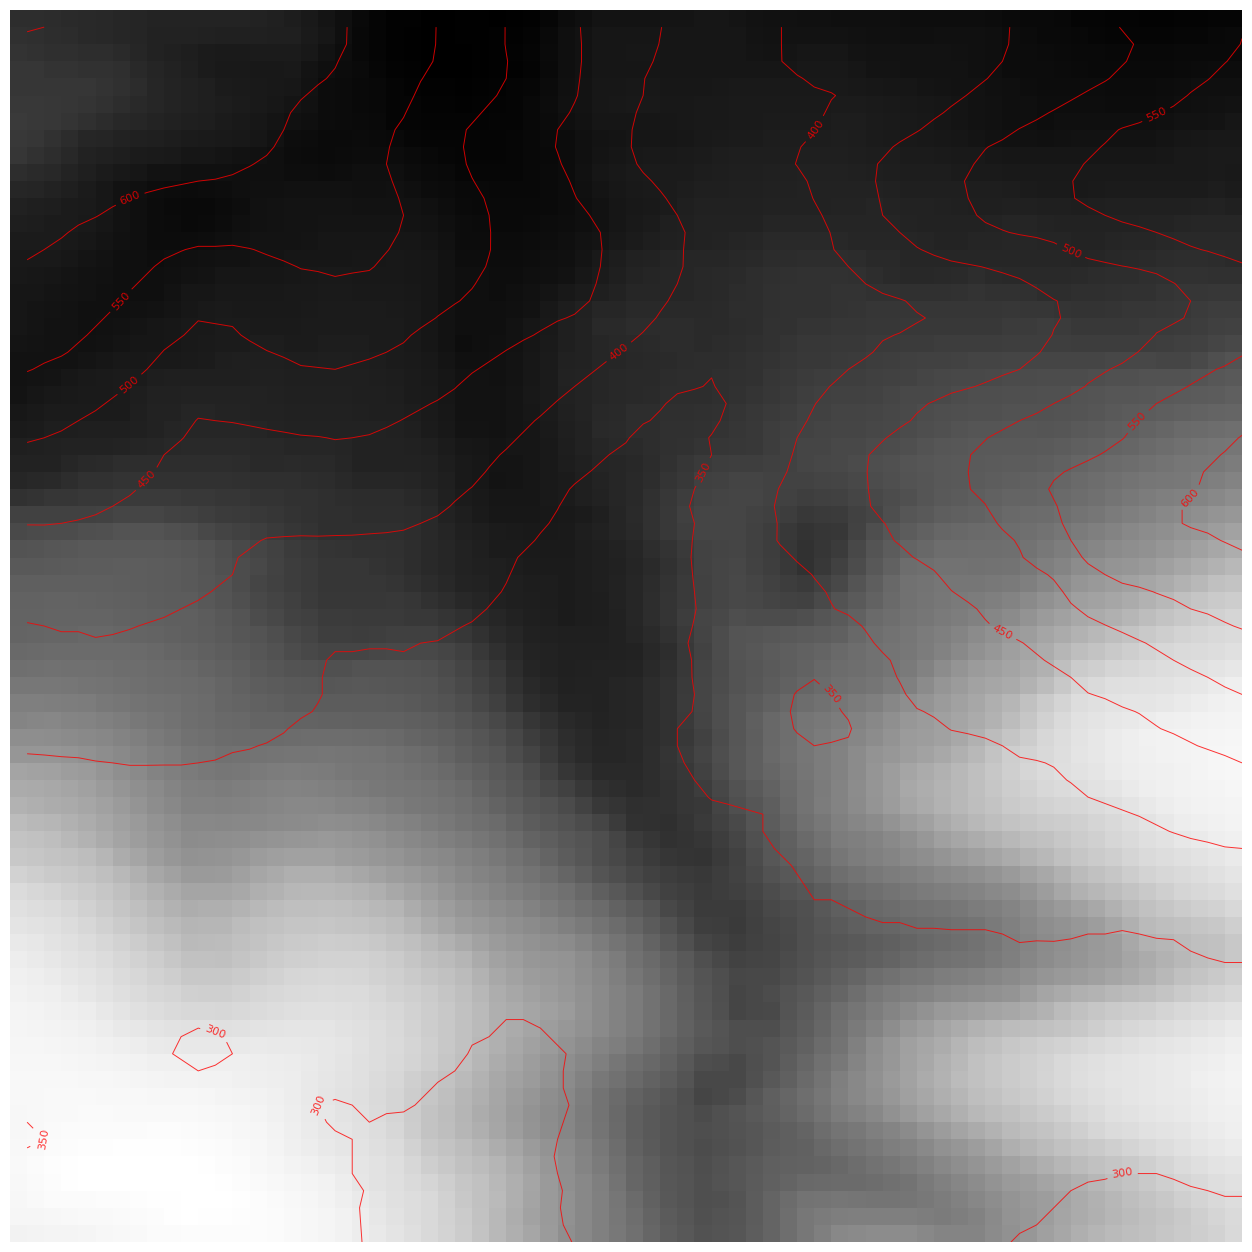

In [3]:
dem_data = rio.open(fname)
dem_array = dem_data.read(1).astype('float64')
fig, ax = plt.subplots(1, figsize=(16, 16))
show(dem_array, cmap='Greys_r', ax=ax)
show(dem_array, contour=True, ax=ax, linewidths=0.7)
plt.axis("off")
plt.show()

In [104]:
# dem_data.index() takes the coordinates (longitude, latitude) and returns the index values of our array. 
# We can use these index values to get the value from the array.
dem_array[dem_data.index(roi[1], roi[0])]

330.0

In [111]:
# dem_data.bounds # bounding box, left, bottom, right, top
utm.from_latlon(*roi)

(597673.4000692789, 5749789.160502992, 32, 'U')

In [7]:
upscale_factor = 30
# # resample data to target shape
data = dem_data.read(1,
    out_shape=( int(dem_data.height * upscale_factor), int(dem_data.width * upscale_factor)),
    out_dtype=np.double,
    resampling=Resampling.bilinear
)

# scale image transform
transform = dem_data.transform * dem_data.transform.scale(
    (dem_data.width / data.shape[-1]),
    (dem_data.height / data.shape[-2])
)

print(data[rio.transform.rowcol(transform, roi[1]+0.005, roi[0]+0.005)])
print(transform)
print(data.shape)
print(data)
# dem_data.read?

# upscale_factor = 30
# from scipy import ndimage
# # Upscale the array
# dem_array_float = dem_array.astype(float)
# dem_array_float = ndimage.gaussian_filter(dem_array_float, sigma=0.33)
# dem_array_float = ndimage.zoom(dem_array_float, upscale_factor).round(decimals=1)


# # Scale the transform matrix
# transform = dem_data.transform * dem_data.transform.scale(
#         (dem_data.width / dem_array_float.shape[-1]),
#         (dem_data.height / dem_array_float.shape[-2])
#     )
# # print(dem_array_float.shape)
# print(dem_array_float[rio.transform.rowcol(transform, roi[1]+0.005, roi[0]+0.005)])

349.0
| 0.00, 0.00, 10.41|
| 0.00,-0.00, 51.90|
| 0.00, 0.00, 1.00|
(2160, 2160)
[[339. 339. 339. ... 294. 294. 294.]
 [339. 339. 339. ... 294. 294. 294.]
 [339. 339. 339. ... 294. 294. 294.]
 ...
 [597. 597. 597. ... 548. 548. 548.]
 [597. 597. 597. ... 548. 548. 548.]
 [597. 597. 597. ... 548. 548. 548.]]


In [103]:
# UTM 32U -> EPSG:32632
west, south, east, north = bbx
src_crs = dem_data.crs
src_shape = src_height, src_width = dem_data.shape
print(src_shape)
src_transform = rio.transform.from_bounds(west, south, east, north, src_width, src_height)
dst_crs = {'init': 'EPSG:32632'}
origin = utm.from_latlon(*roi)[:2]
# dst_transform = rio.transform.from_origin(597673.40, 5749789.16, 250, 250)
dst_transform = rio.transform.from_origin(origin[0], origin[1], 1, 1)
dem_array_out = np.zeros((72, 72))
dem_array_out[:] = np.nan
reproject(dem_array,
          dem_array_out,
          src_transform=src_transform,
          src_crs=src_crs,
          dst_transform=dst_transform,
          dst_crs=dst_crs,
          resampling=Resampling.bilinear);


(72, 72)


330.0

In [67]:
cols, rows = np.meshgrid(np.arange(src_width), np.arange(src_height))
xs, ys = rio.transform.xy(dem_roi.transform, rows, cols)
lngs= np.array(xs)
lats = np.array(ys)
lngs

array([[10.40944444, 10.40972222, 10.41      , ..., 10.42861111,
        10.42888889, 10.42916667],
       [10.40944444, 10.40972222, 10.41      , ..., 10.42861111,
        10.42888889, 10.42916667],
       [10.40944444, 10.40972222, 10.41      , ..., 10.42861111,
        10.42888889, 10.42916667],
       ...,
       [10.40944444, 10.40972222, 10.41      , ..., 10.42861111,
        10.42888889, 10.42916667],
       [10.40944444, 10.40972222, 10.41      , ..., 10.42861111,
        10.42888889, 10.42916667],
       [10.40944444, 10.40972222, 10.41      , ..., 10.42861111,
        10.42888889, 10.42916667]])

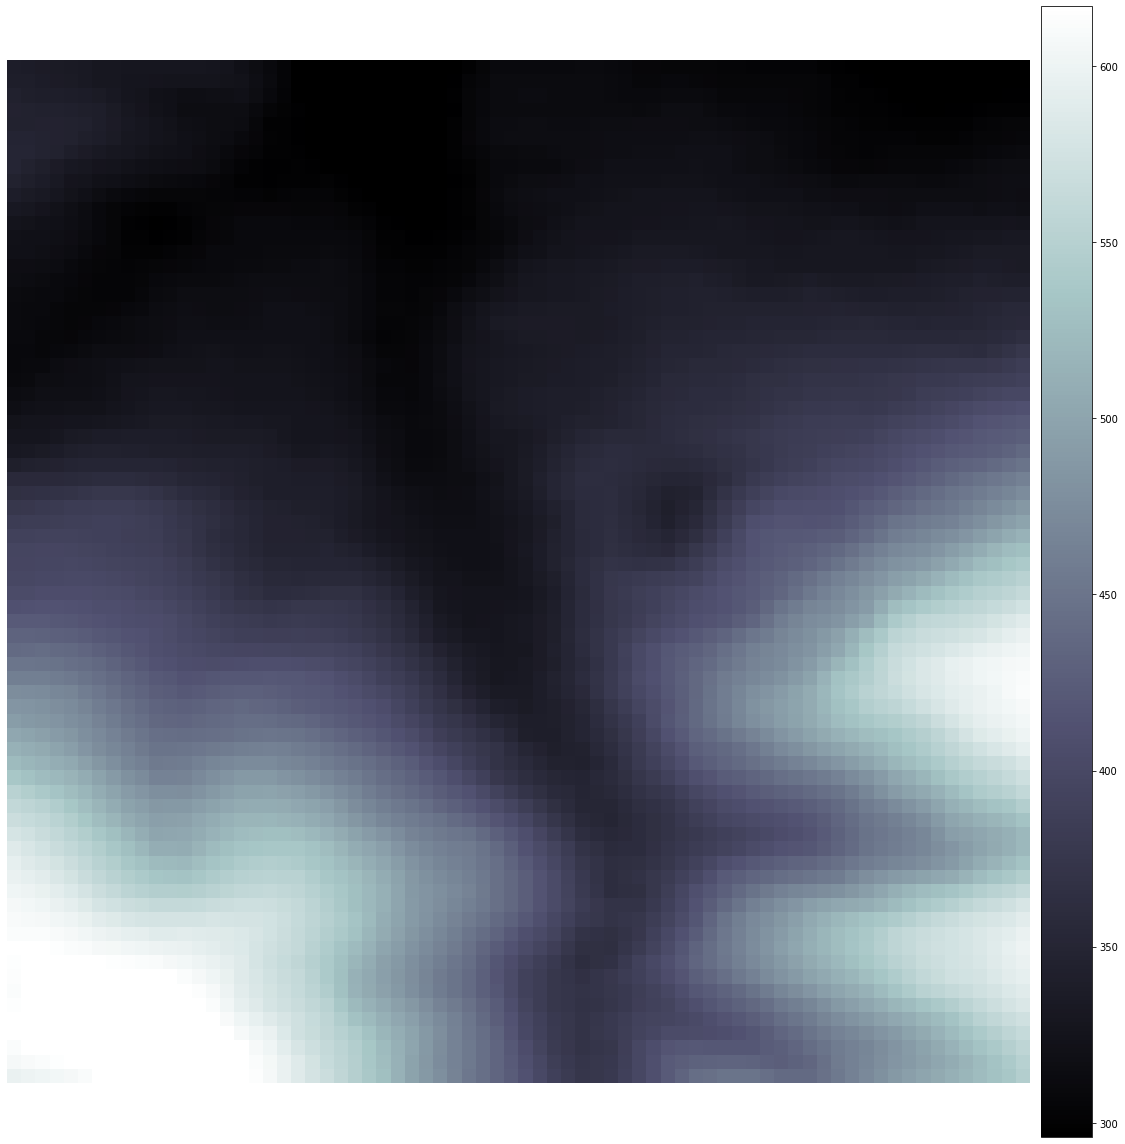

{'vmin': 296.0, 'vmax': 617.0}

In [45]:
dem_richdem = rd.rdarray(dem_array, no_data=-9999)
fig = rd.rdShow(dem_richdem, axes=False, cmap='bone', figsize=(16, 16));
fig

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


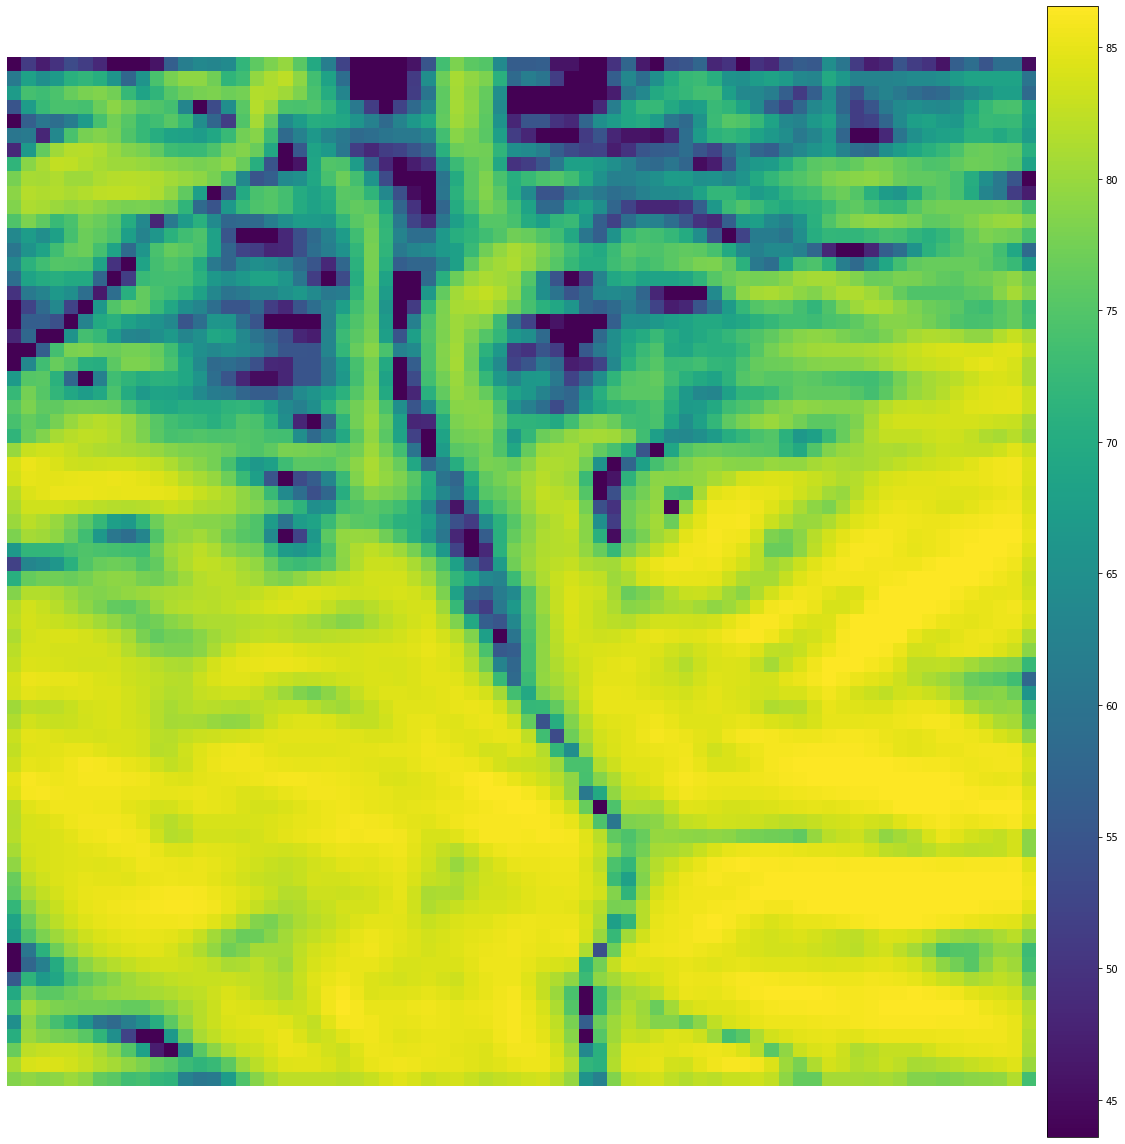

In [46]:
dem_slope = rd.TerrainAttribute(dem_richdem, attrib='slope_degrees')
# rd.rdShow(dem_slope, axes=False, cmap='YlOrBr', figsize=(16, 16));
rd.rdShow(dem_slope, axes=False, cmap='viridis', figsize=(16, 16));

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


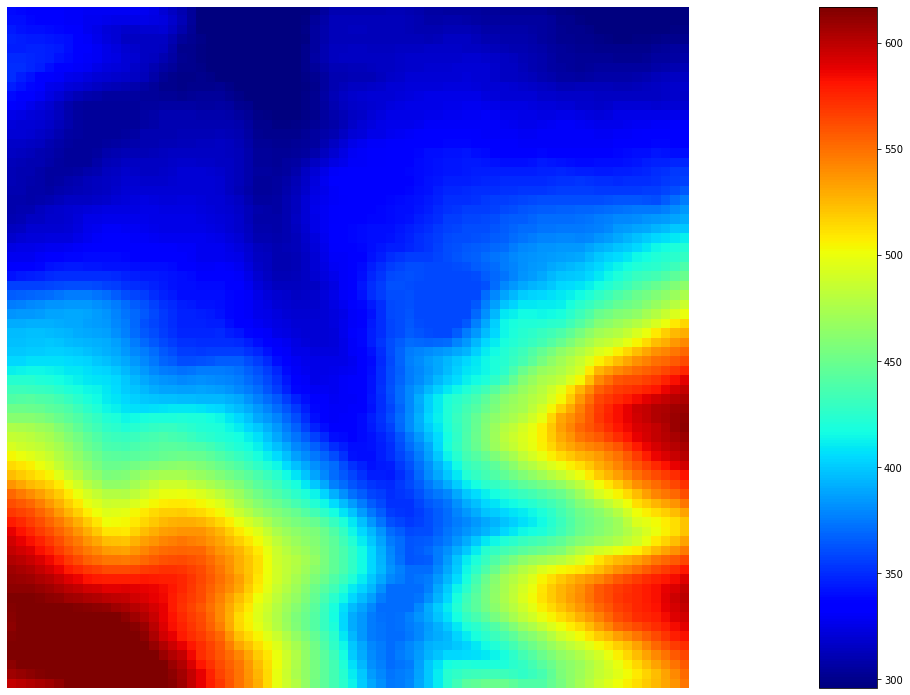

In [40]:
dem_filled = rd.FillDepressions(dem_richdem, in_place=False)
dem_filled_fig = rd.rdShow(dem_filled, ignore_colours=[0], axes=False, cmap='jet', vmin=fig['vmin'], vmax=fig['vmax'], figsize=(16,10))

In [41]:
# roi = (49.81061769757704, 9.988233595428222)
# gdf = ox.geometries_from_point(roi, dist=200, tags={'building': True})
# gdf = ox.projection.project_gdf(gdf, to_crs='epsg:3857')
# ox.plot_footprints(gdf)
# gdf